In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
from astropy.io import fits
from astropy.stats import LombScargle
import h5py
import healpy
from healpy.sphtfunc import Alm
import pystan

Compile the stan model:

In [3]:
model = pystan.StanModel(file='emission_map.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13969a26213622aee06d87aa0413d80c NOW.
/mnt/home/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpc238qbij/stanfit4anon_model_13969a26213622aee06d87aa0413d80c_6131439144894811989.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Load the Maia data:

In [4]:
with fits.open('maia_k2sc.fits', 'readonly') as f:
    ts = f[1].data['time']
    flux = f[1].data['flux'] - f[1].data['trposi'] + np.nanmedian(f[1].data['trposi'])
    flux_error = f[1].data['error']

Raw data:

Text(0, 0.5, '$F(t)$ (arb. units)')

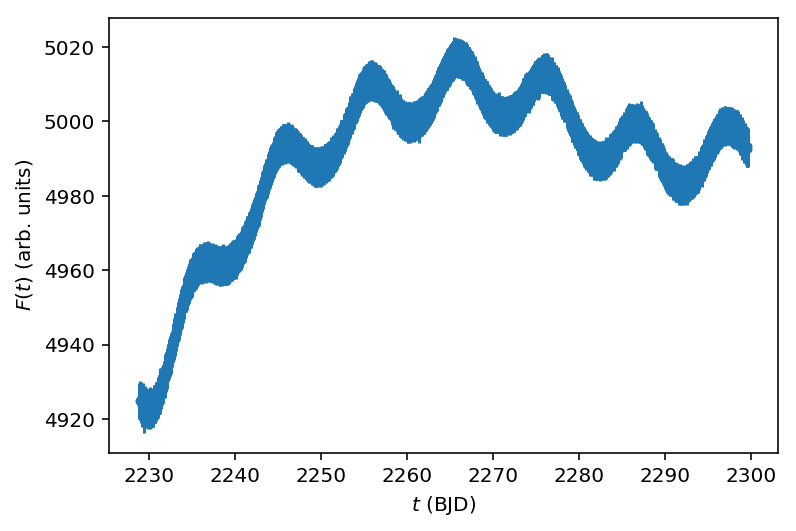

In [11]:
errorbar(ts, flux, flux_error, fmt='.')
xlabel(r'$t$ (BJD)')
ylabel(r'$F(t)$ (arb. units)')

We are *way* over-sampled to extract the $\sim 10 \, \mathrm{d}$ signal in this lightcurve.  Let's do a moving average with a timescale of 1 day.

Text(0, 0.5, '$F(t)$ (arb. units)')

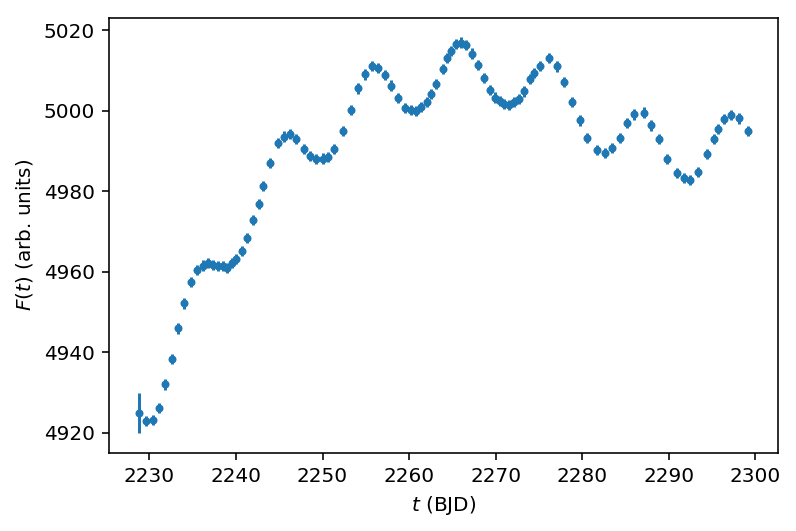

In [12]:
ma_flux = [flux[0]]
ma_flux_error = [flux_error[0]]
for i in range(1, len(ts)):
    dt = ts[i] - ts[i-1]
    wt = exp(-dt)
    
    wt0 = 1.0/(1.0 + wt)
    wt1 = wt/(1.0 + wt)
    
    ma_flux.append(wt0*flux[i] + wt1*ma_flux[-1])
    ma_flux_error.append(sqrt(wt0*wt0*flux_error[i] + wt1*wt1*ma_flux_error[-1]))
ma_flux = array(ma_flux)
ma_flux_error = array(ma_flux_error)

dec_factor = int(round(1/diff(ts)[0]))
ts_ma = ts[::dec_factor]
ma_flux = ma_flux[::dec_factor]
ma_flux_error = ma_flux_error[::dec_factor]

errorbar(ts_ma, ma_flux, ma_flux_error, fmt='.')

xlabel(r'$t$ (BJD)')
ylabel(r'$F(t)$ (arb. units)')

It will be convenient to standardize the lightcurve:

Text(0, 0.5, '$\\left( F(t) - \\left\\langle F(t) \\right\\rangle \\right)/\\sigma_F$')

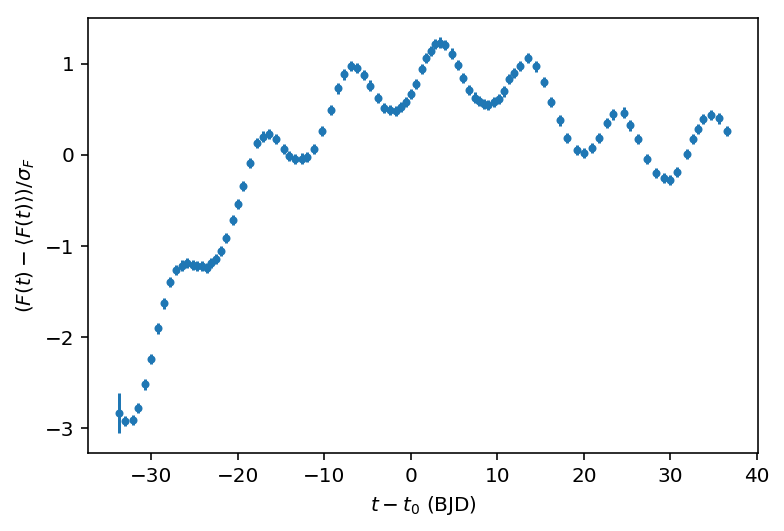

In [13]:
mu = mean(ma_flux)
sigma = std(ma_flux)

ma_flux = (ma_flux-mu)/sigma
ma_flux_error = ma_flux_error/sigma

ts_ma = ts_ma-median(ts_ma)

errorbar(ts_ma, ma_flux, ma_flux_error, fmt='.')

xlabel(r'$t-t_0$ (BJD)')
ylabel(r'$\left( F(t) - \left\langle F(t) \right\rangle \right)/\sigma_F$')

Let's look at the frequency content of the lightcurve:

In [14]:
f, p = LombScargle(ts_ma, ma_flux, ma_flux_error).autopower()

That peak near $1/10 \, \mathrm{d}^{-1}$ is the one we want:

Text(0, 0.5, '$P(f)$ (arb. units)')

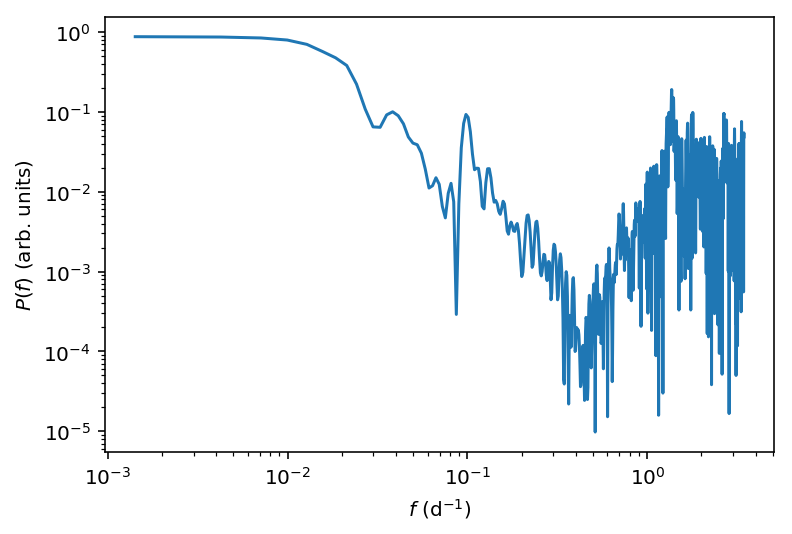

In [15]:
loglog(f, p)
xlabel(r'$f$ ($\mathrm{d}^{-1}$)')
ylabel(r'$P(f)$ (arb. units)')

Here we fit for the period and the uncertainty in the period from the L-S periodogram peak:

Text(0, 0.5, '$P(f)$ (arb. units)')

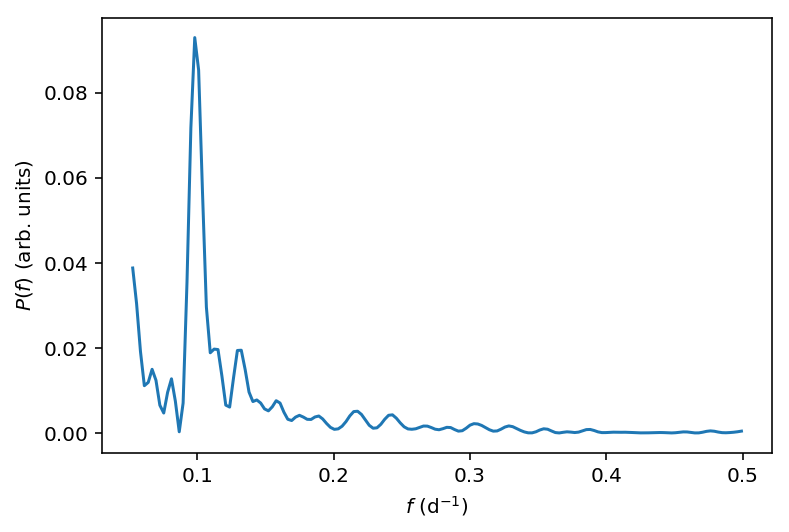

In [16]:
s = (0.05 < f) & (f < 0.5)
plot(f[s], p[s])

xlabel(r'$f$ ($\mathrm{d}^{-1}$)')
ylabel(r'$P(f)$ (arb. units)')

We extract the best-fit period and the uncertainty by doing a quadratic fit to the three bins in the L-S periodogram surrounding the peak.

In [11]:
im = argmax(p[s])
f0 = f[s][im-1]
f1 = f[s][im]
f2 = f[s][im+1]

p0 = p[s][im-1]
p1 = p[s][im]
p2 = p[s][im+1]

fbest = (f2**2*(p0-p1) + f0**2*(p1-p2) + f1**2*(p2-p0))/(2.0*(f2*(p0-p1) + f0*(p1-p2) + f1*(p2-p0)))
sigma_f = sqrt(-(f2-f0)/(2.0*((p1-p0)/(f0-f1) + (p1-p2)/(f1-f2))))

pbest = 1.0/fbest
sigma_p = 1.0/fbest**2*sigma_f

(pbest, sigma_p)

(10.123048260461072, 1.7161245579839177)

Clearly there is a lot of power at long timescales; we need to fit that out.  Here we will use a low-order polynomial fit.  We generate the design matrix for the fit, and then SVD it to get an orthogonal basis of lightcurves with which to do the fitting.  There are ~seven periods of the periodic signal in the data set, so I would expect that we could go up to ~14th order before running into degeneracies with the periodic part of the lightcurve....

We use SVD to orthogonalize the basis over the measured times, and normalize to a maximum value of 1.

In [18]:
t0 = median(ts_ma)
c = ones_like(ts_ma)
cols = [c]
for i in range(1, 7):
    c = c*(ts_ma-t0)
    cols.append(c)
M = column_stack(cols)
u, s, v = linalg.svd(M, full_matrices=False)

# Normalize to max() == 1
for j in range(u.shape[1]):
    u[:,j] /= np.max(np.abs(u[:,j]))

Here are the orthogonal basis components:

Text(0, 0.5, '$F(t)$ (normalized)')

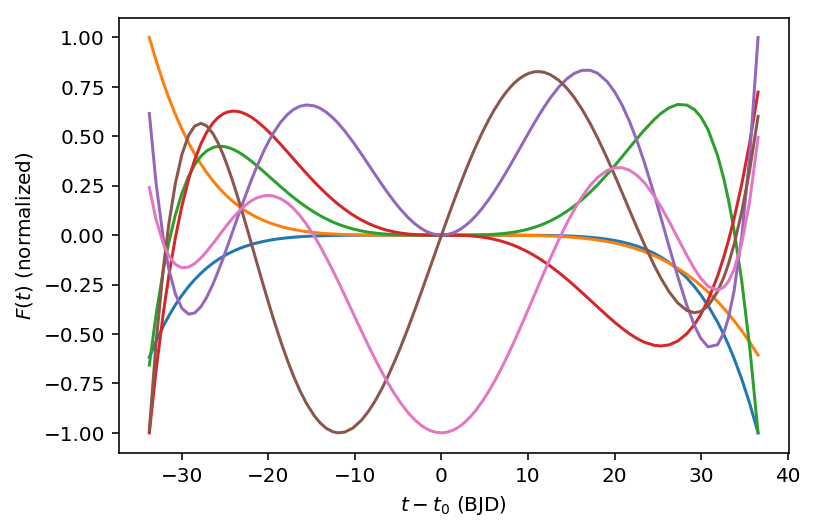

In [20]:
for j in range(u.shape[1]):
    plot(ts_ma, u[:,j])
    
xlabel(r'$t-t_0$ (BJD)')
ylabel(r'$F(t)$ (normalized)')

We need to generate the matrix that transforms the $a_{lm}$ basis to pixels.  We use healpix to do that.  Since we have low-pass filtered and decimated the data to $1\, \mathrm{d}$ spacing, $m=5$ is basically at the Nyquist frequency for the data.  We will go right up to this bound, using $l_\mathrm{max} = 5$.  We ensure that we have enough pixels that we are also over-resolved.

In [ ]:
lmax = 5
nside = 2 # Over-resolved with l = 7: 64 alm's, but 190 pixels.
Ylm_matrix = []
ls = []
for l in range(lmax+1):
    for m in range(0, l+1):
        alm_array = zeros(Alm.getsize(lmax), dtype=np.complex)
        alm_array[Alm.getidx(lmax, l, m)] = 1.0
        Ylm_matrix.append(healpy.alm2map(alm_array, nside))
        ls.append(l)
        if m > 0:
            alm_array[Alm.getidx(lmax, l, m)] = 1.0j
            Ylm_matrix.append(healpy.alm2map(alm_array, nside))
            ls.append(l)
Ylm_matrix = array(Ylm_matrix).T
ls = array(ls, dtype=np.int)

# We drop the l = 0, m = 0 component because it is degenerate with the trend components.
Ylm_matrix = Ylm_matrix[:, 1:]
ls = ls[1:]

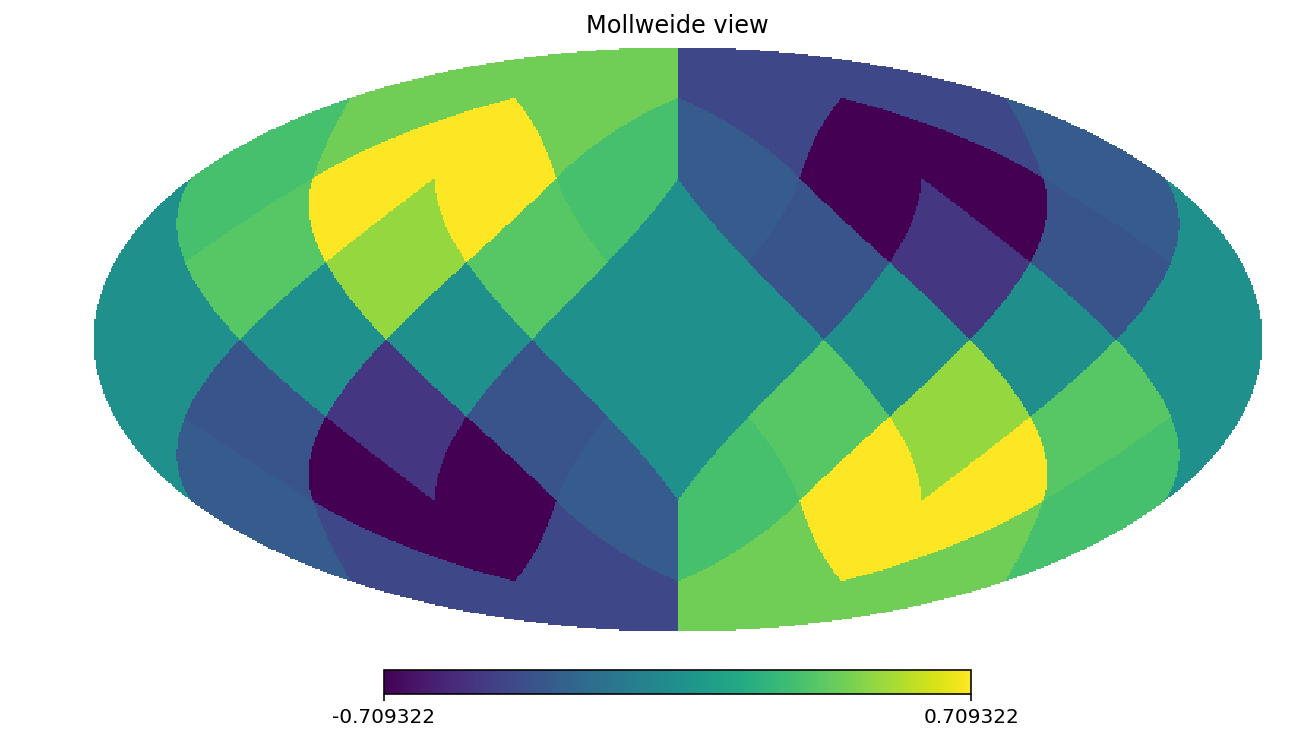

In [16]:
healpy.mollview(Ylm_matrix[:,5])

We are over-sampled relative to the $Y_{lm}$ basis, which is good:

In [17]:
Ylm_matrix.shape

(48, 35)

The pattern is from $m=0$ to $m=l$, alternating positive and negative $m$, before incrementing $l$.

In [18]:
ls

array([1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

The final thing we need is the pixel vectors.

In [19]:
pix_nhat = []
for i in range(healpy.nside2npix(nside)):
    pix_nhat.append(healpy.pix2vec(nside, i))
pix_nhat = array(pix_nhat)

We construct the data dictionary for the fit, which contains all the pre-computed elements needed to calculate the lightcurves.

In [20]:
data = {
    'lmax': lmax,
    'nalm': Ylm_matrix.shape[1],
    'npix': Ylm_matrix.shape[0],
    'ntrend': u.shape[1],
    
    'nobs': len(ts_ma),
    
    'l_alm': ls,
    
    'sht_matrix': Ylm_matrix,
    
    'pix_area': healpy.nside2pixarea(nside),
    'pix_nhat': pix_nhat,
    
    'time': ts_ma, # zero phase happens at middle of array
    'flux': ma_flux,
    'sigma_flux': ma_flux_error,
    
    'trend_basis': u,
    
    'Pmin': pbest - 5.0*sigma_p,
    'Pmax': pbest + 5.0*sigma_p,
    
    'mu_P': pbest,
    'sigma_P': 2.0*sigma_p,
    
    'cos_iota_min': 0.0,
    'cos_iota_max': 1.0,
}

The sampler has a lot of trouble converging on the right period if we don't start it near there (once you are too far away, there is no gradient any more), so we write a specialized initalization function that places the period very close to the best-fit value.

In [21]:
def init(chain=None):
    l = 1 + 0.5*randn()
    while l < 0 or l > lmax:
        if l < 0:
            l = -l
            
        if l > lmax:
            l = 2.0*lmax - l
    
    ci = 0.95 + 0.02*randn()
    while ci < 0 or ci > 1:
        if ci < 0:
            ci = -ci
            
        if ci > 1:
            ci = 2.0 - ci
    
    P = pbest + 0.001*randn()
    
    return {
        'sigma': abs(0.2 + 0.1*randn()),
        'lambda': l,
        'cos_iota': ci,
        'P': P
    }

And here is the fit.  Note that we are asking Stan to estimate a dense metric for the kinetic terms---this adjusts the "mass matrix" to match the observed correlations in the posterior.  **No released version of Stan does this correctly** due to a bug; you will need to apply the patch from commit e1f4e7a6abbb318258b513a690af629f64eb018f referred to in this issue in order for this to work correctly: https://github.com/stan-dev/stan/issues/2671.  Adapting to the correlations reduces the run time for this problem by an order of magnitude or more.

In [22]:
fit = model.sampling(data=data, control={'metric': 'dense_e'}, init=init)
chain = fit.extract(permuted=True)

Plot a trace of the sampled-over variables:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaf3f86fd0>,
      dtype=object)

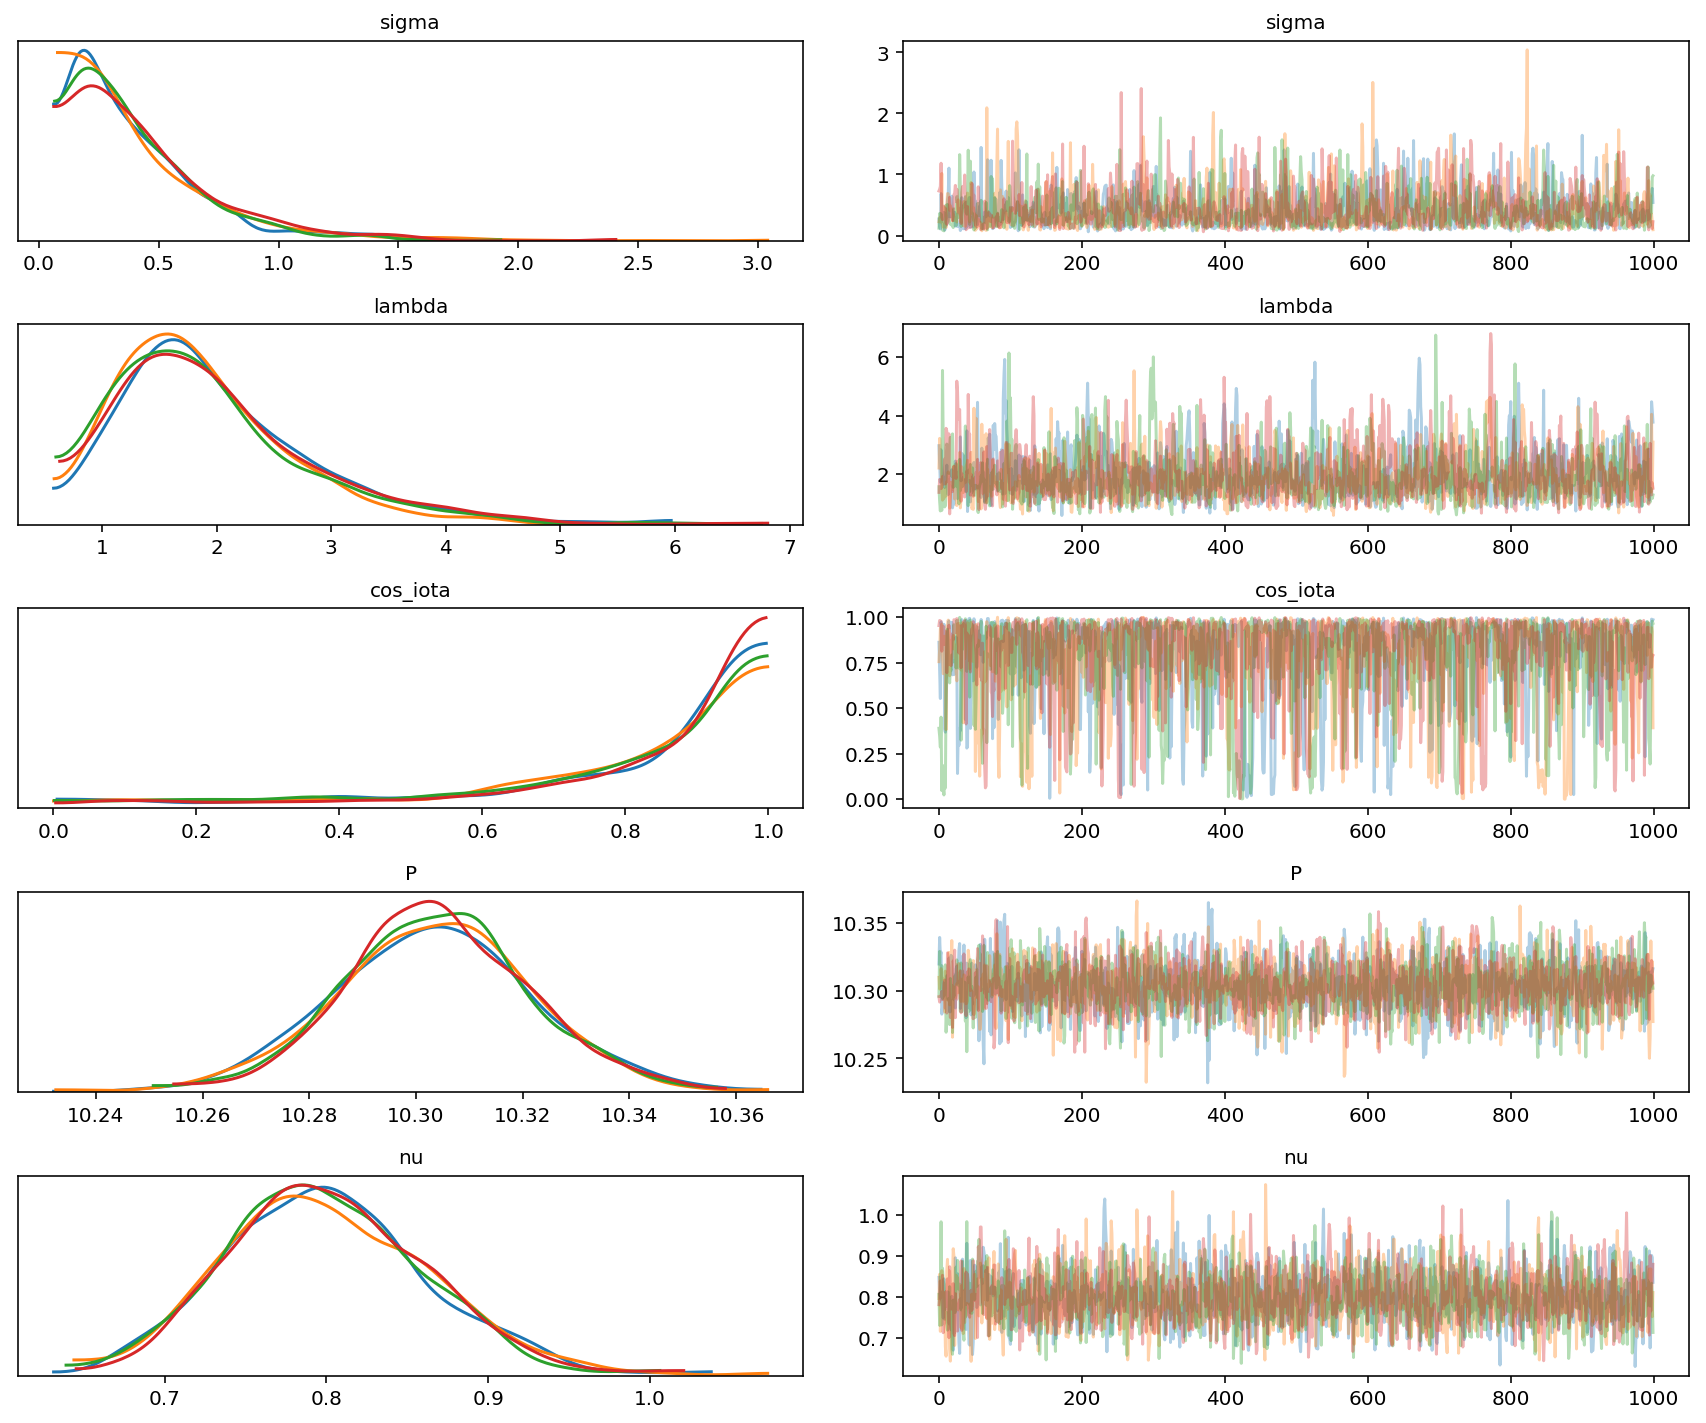

In [23]:
az.plot_trace(fit, var_names=['sigma', 'lambda', 'cos_iota', 'P', 'nu'])

And save the chain, reshaping to ``(nchains, nsamples, ...)`` shape for ``arviz`` to process later:

In [24]:
with h5py.File('chain.h5', 'w') as f:
    for n in chain.keys():
        f.create_dataset(n, data=reshape(chain[n], (4, -1) + chain[n].shape[1:]), compression='gzip', shuffle=True)

Re-load the chain:

In [22]:
chain = {}
with h5py.File('chain.h5', 'r') as f:
    for k in f.keys():
        chain[k] = array(f[k])
        
nchain, nsamp = chain['P'].shape

Here is the observations (in black, with re-scaled errorbars) and the mean predicted lightcurve (top); also the residuals between mean and observed (bottom).  There is some sort of decrement feature clearly present in the data around $t = 20$ (we have re-centered the times on the median time from the data set); perhaps using the actual detrending based on comoving basis vectors (or whatever was done in the Maia paper) would remove this?  Or, perhaps we are seeing dynamic spot formation on the star?

Text(0, 0.5, '$\\left( F(t) - \\left\\langle F(t) \\right\\rangle \\right)/\\sigma_F - F_\\mathrm{model}(t)$')

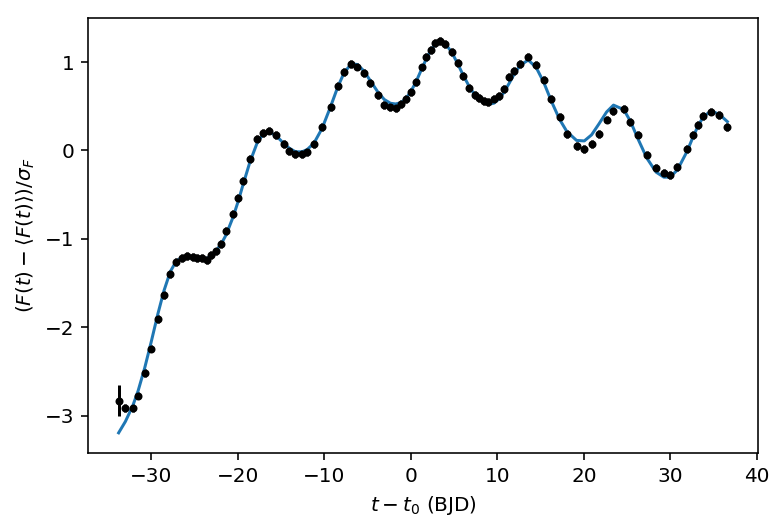

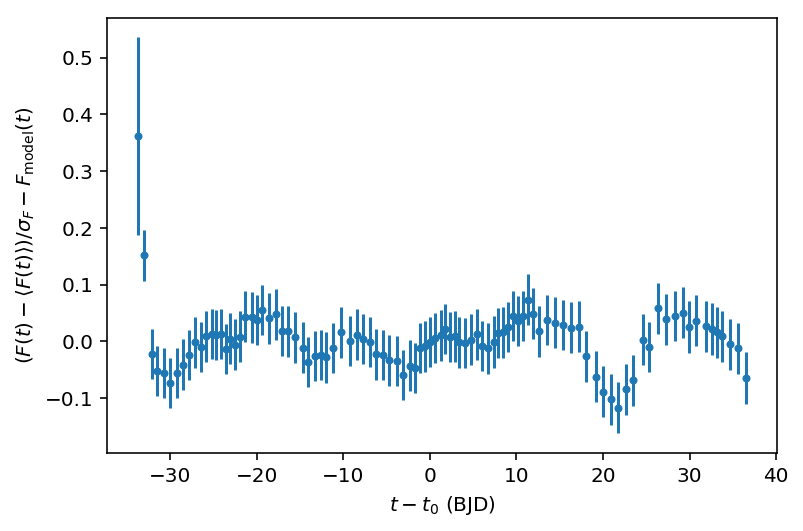

In [23]:
plot(ts_ma, mean(chain['lightcurve'], axis=(0,1)))
errorbar(ts_ma, ma_flux, mean(chain['nu'])*ma_flux_error, fmt='.', color='k')

xlabel(r'$t-t_0$ (BJD)')
ylabel(r'$\left( F(t) - \left\langle F(t) \right\rangle \right)/\sigma_F$')


figure()
errorbar(ts_ma, ma_flux-mean(chain['lightcurve'], axis=(0,1)), mean(chain['nu'])*ma_flux_error, fmt='.')

xlabel(r'$t-t_0$ (BJD)')
ylabel(r'$\left( F(t) - \left\langle F(t) \right\rangle \right)/\sigma_F - F_\mathrm{model}(t)$')

The ``view_map`` function makes pretty maps by up-sampling and then smoothing on the pixel scale of the original map.

In [24]:
def view_map(m):
    healpy.orthview(healpy.smoothing(healpy.ud_grade(m, 128), fwhm=healpy.nside2resol(nside)))

Here is the posterior mean map (by linearity, this will also generate the mean light curve):

Sigma is 746.965377 arcmin (0.217283 rad) 
-> fwhm is 1758.969043 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


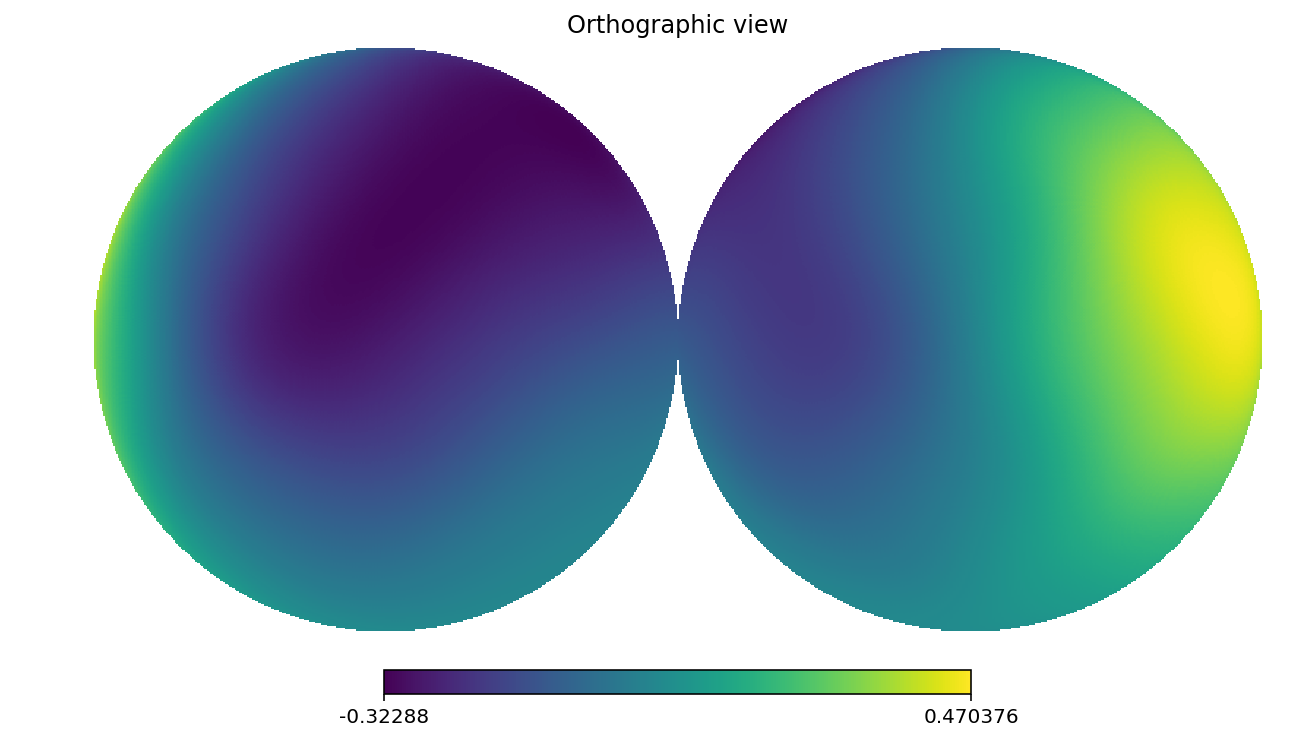

In [27]:
view_map(mean(chain['pix_map'], axis=(0,1)))

Execute the cell below to see maps drawn from the posterior; they look broadly similar to the mean map.

Sigma is 746.965377 arcmin (0.217283 rad) 
-> fwhm is 1758.969043 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


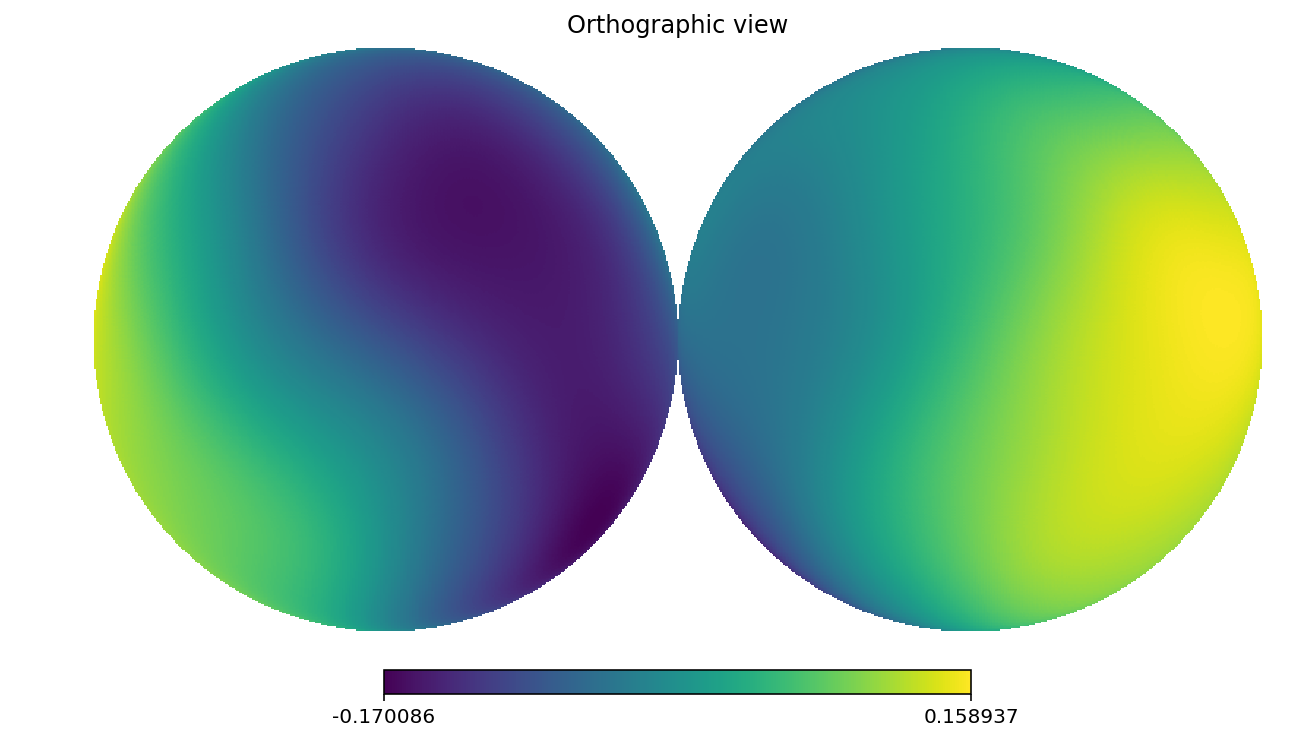

In [28]:
view_map(chain['pix_map'][randint(nchain), randint(nsamp), :])

1D posteriors for the period (1-sigma uncertainty ~0.02 d), the inclination (prefers equator-on, but really weak constraint), the angular frequency scale ($\lambda$ in the squared exponential kernel in $l$-space, the corresponding angular correlation scale corresponds roughly to $\pi/\lambda$ radians; we have a prefernce for *big* spots, ~90 deg across, as opposed to fine scales), and the errorbar scale factor (over-estimated errors by ~20%). 

P = 10.303 +/- 0.018 d (mean +/- s.d.)
cos(iota) > 0.10 (obliquity < 84 deg; 95% CI)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c24926ac8>],
      dtype=object)

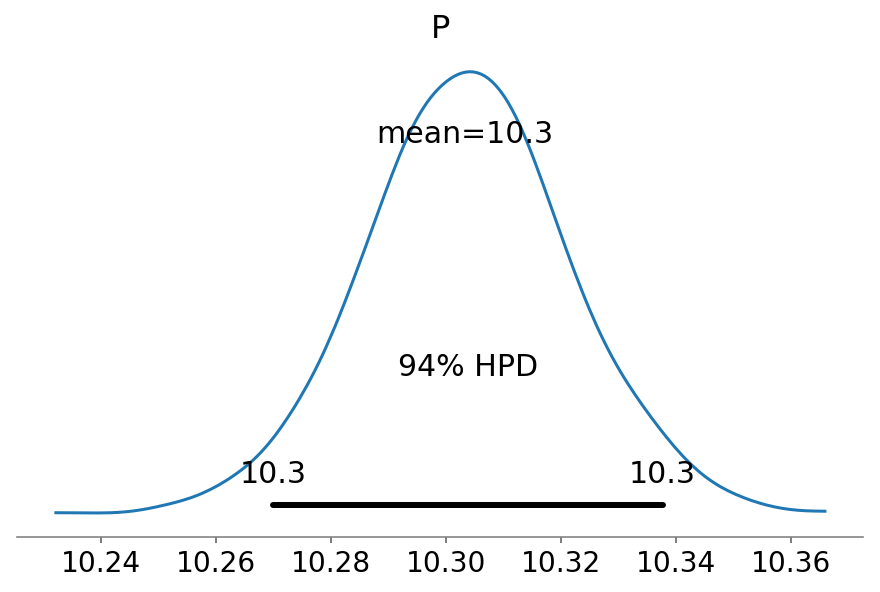

<Figure size 432x288 with 0 Axes>

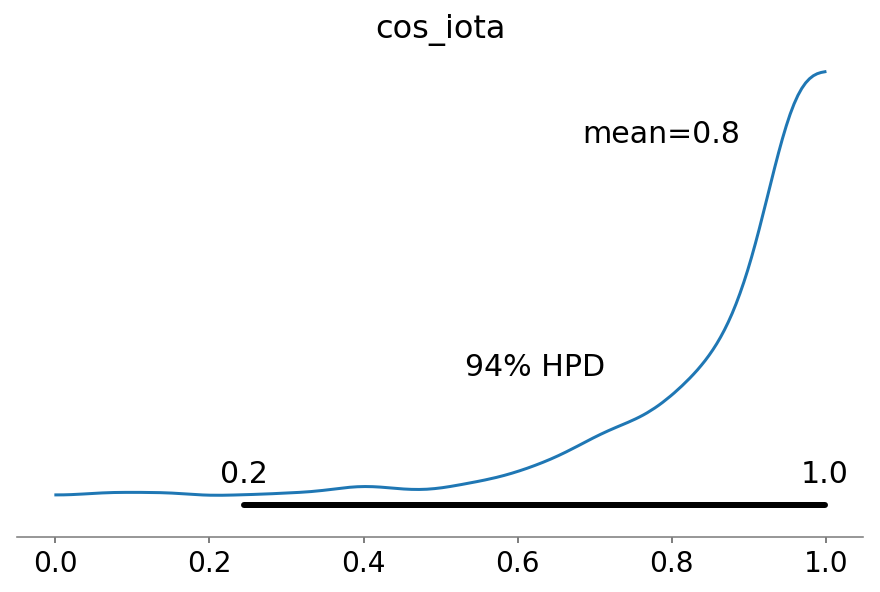

<Figure size 432x288 with 0 Axes>

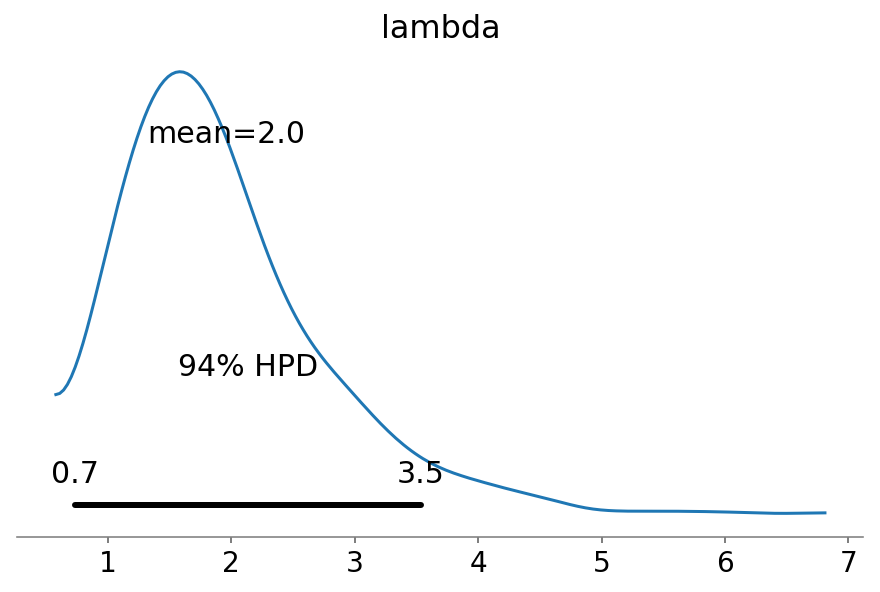

<Figure size 432x288 with 0 Axes>

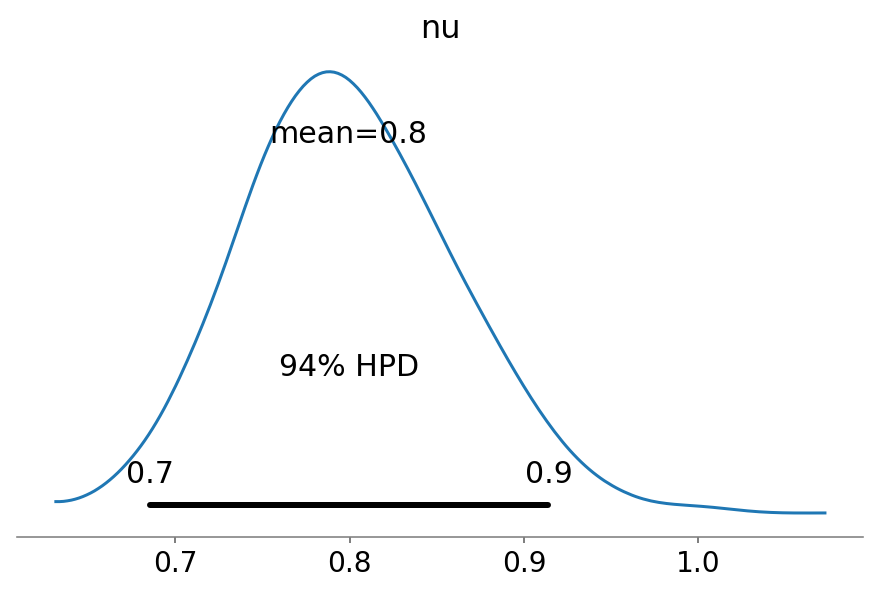

In [29]:
az.plot_posterior(chain, var_names=['P'])
print('P = {:.3f} +/- {:.3f} d (mean +/- s.d.)'.format(mean(chain['P']), std(chain['P'])))

figure()
az.plot_posterior(chain, var_names=['cos_iota'])
print('cos(iota) > {:.2f} (obliquity < {:.0f} deg; 95% CI)'.format(percentile(chain['cos_iota'], 2.5), 180/pi*arccos(percentile(chain['cos_iota'], 2.5))))

figure()
az.plot_posterior(chain, var_names=['lambda'])

figure()
az.plot_posterior(chain, var_names=['nu'])

Posterior over the power spectra of the maps.  (Our normalization condition is that $C_l = \left\langle \left| a_{lm} \right|^2 \right\rangle$ for $-l \leq m \leq l$.)

Text(0, 0.5, '$\\sqrt{C_l}$')

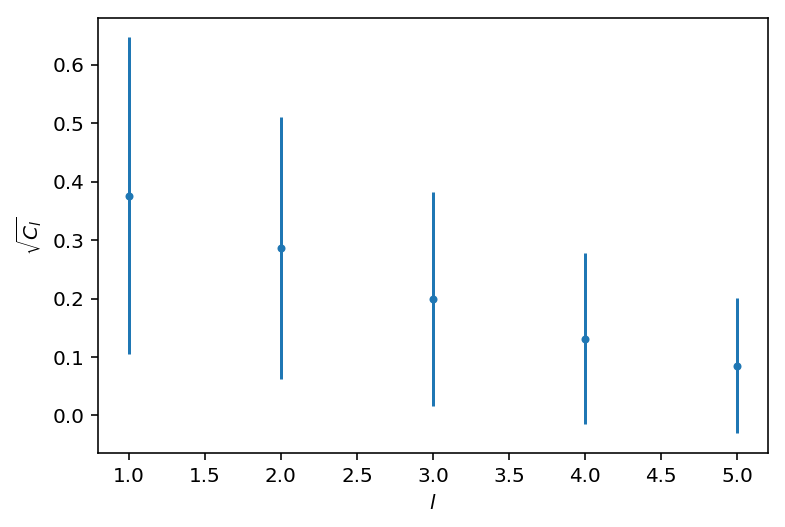

In [30]:
_, inds = unique(ls, return_index=True)

sCls = chain['sqrt_Cl'][:,:,inds]

errorbar(ls[inds], mean(sCls, axis=(0,1)), std(sCls, axis=(0,1)), fmt='.')

xlabel(r'$l$')
ylabel(r'$\sqrt{C_l}$')